In [184]:
import spacy
import html
from sklearn import cluster, decomposition
import sklearn.decomposition.pca as pca
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gzip
import jsonlines
import string
import re
import requests
import os
from collections import Counter
sns.set()

In [140]:
nlp = spacy.load('en_core_web_md')

In [159]:
with gzip.open("../data/articles.jl.gz", "rb") as fh:
    with jsonlines.Reader(fh) as reader:
        raw_articles = [item for item in reader]
        print(f"articles count: {len(raw_articles)}")
        
with gzip.open("../data/annotations.jl.gz", "rb") as fh:
    with jsonlines.Reader(fh) as reader:
        raw_annotations = [item for item in reader]
        print(f"annotations count: {len(raw_annotations)}")
        
with gzip.open("../data/locations.jl.gz", "rb") as fh:
    with jsonlines.Reader(fh) as reader:
        raw_locations = [item for item in reader]
        print(f"locations count: {len(raw_locations)}")

articles count: 9959
annotations count: 3221
locations count: 3562


In [142]:
def summarize_text(text, start=30, end=10):
    return f"{text[:start]}...{text[-end:]}"

def pretty_dict(d):
    return json.dumps(d, indent=4)

In [160]:
annotation_histogram = Counter()
publisher_histogram = Counter()
for i, raw_doc in enumerate(raw_articles):
    annotation_histogram[len(raw_doc["annotation_uri"])] += 1
    publisher_histogram[raw_doc["publisher"]] += 1


Let's display the distribution of annotations/locations over the article dataset.

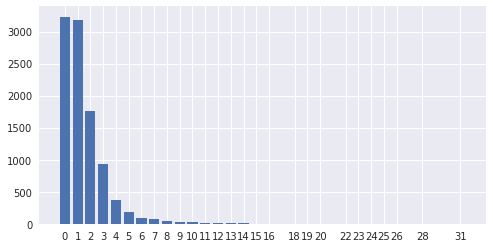

In [161]:
fig = plt.figure(figsize=(8,4))
plt.bar(annotation_histogram.keys(), annotation_histogram.values(),tick_label=[k for k in annotation_histogram.keys()]);


Likewise for the distribution of publishers:

In [ ]:
print("most 2 common publishers: ", publisher_histogram.most_common(2), "\n")
for k,v in publisher_histogram.items():
    print(k.ljust(35)," | count:" ,v)

We notice that some publisher may belong to the same group but have different name. for example, "birminghammail" and "birminghammail.com"

We're going to clean up the publishers name to possibly

In [146]:
[a for a in raw_articles if "fc882fe3-0c53-42a0-aef3-f775a372a0cc" == a["iid"].lower()]

[]

1530327500000

In [147]:
min(raw_articles, key=lambda x: x["lastModifiedTime"])

{'iid': 'ff063c7c-93ee-450a-8bb9-6305bba8b6e2',
 'lastModifiedTime': 1530327600000,
 'publisher': 'Dorset Echo',
 'published_time': None,
 'annotation_uri': [],
 'id': 'ff063c7c-93ee-450a-8bb9-6305bba8b6e2',
 'url': 'http://www.dorsetecho.co.uk/news/16324152.dorset-wildfire-advisor-is-on-standby-to-help-with-saddleworth-blaze/',
 'articleid': None,
 'previous_id': None,
 'type': 'articles',
 'title': 'Dorset wildfire advisor is on standby to help with Saddleworth blaze',
 'cleantitle': None,
 'description': 'A WILDFIRE tactical advisor for Dorset and Wiltshire Fire and Rescue Service has been put on standby in case he is needed to help tackle the fire…',
 'body': 'A WILDFIRE tactical advisor for Dorset and Wiltshire Fire and Rescue Service has been put on standby in case he is needed to help tackle the fire near Saddleworth Moor in Greater Manchester.\nAssistance in tackling the fire, which is expected to continue for several days or weeks more, has been provided by other fire services

In [123]:
set([a["publisher"] for a in raw_articles if "birm" in a["publisher"].lower()])

{'birminghammail', 'www.birminghammail.co.uk'}

In [186]:
os.path.splitext("starandcrescent.org.uk")

('starandcrescent.org', '.uk')

In [212]:
pattern = re.compile("www\.| |\.com|\.co\.uk|\.org|\.uk")

def clean_publisher(publisher):
    # clean websites name
    # Note that using split may have us miss names like edinburghnews.scotsman.com
    publisher = pattern.sub("", publisher)
    publisher = publisher.lower()
    return publisher

publishers = set([a["publisher"] for a in raw_articles])

In [213]:
publisher = "www.londonnewsonline.co.uk"

In [214]:
clean_publisher_histogram = Counter()
for i, raw_doc in enumerate(raw_articles):
    clean_publisher_histogram[clean_publisher(raw_doc["publisher"])] += 1

In [215]:
print(len(publisher_histogram))
print(len(clean_publisher_histogram))

384
378


In [216]:
raw_doc = raw_articles[99]
print(pretty_dict(raw_doc))

{
    "iid": "ec5c176d-ceb4-46dc-ae68-60bac4056753",
    "lastModifiedTime": 1530469114000,
    "publisher": "The Courier",
    "published_time": null,
    "annotation_uri": [
        "f99c3a35f03a8eb7f3b0bb044b8e5506",
        "5c8ad4f4220ed87d24fbdc261c243091",
        "09b4a5eed6a1e20bb5b5088055163607"
    ],
    "id": "ec5c176d-ceb4-46dc-ae68-60bac4056753",
    "url": "https://www.thecourier.co.uk/news/uk-world/680465/russia-fans-party-hard-after-team-knocks-spain-out-of-world-cup/",
    "articleid": null,
    "previous_id": null,
    "type": "articles",
    "title": "Russia fans party hard after team knocks Spain out of World Cup",
    "cleantitle": null,
    "description": "Russia fans wept and leapt for joy as Moscow went into meltdown after their football team knocked Spain out of the World Cup on penalties.",
    "body": "New data has shown the Queensferry Crossing is improving the reliability of crossing the Forth. As the heatwave continues to bake many parts of the UK, zooke

In [70]:
limit = 20
for i, raw_doc in enumerate(raw_articles):
    print(f"{i}".ljust(2), " | ", raw_doc["publisher"].ljust(35), " | ", raw_doc["id"], " | ", summarize_text(raw_doc["title"]))
    if limit and limit <= i:
        break

0   |  www.nwemail.co.uk                    |  9764d074-d5e1-44ee-99be-4bf910d2ded3  |  Britain told it must follow EU...- The Mail
1   |  www.rotherhamadvertiser.co.uk        |  f405538d-46a2-4edf-96cb-18e526303c19  |  Full Rotherham United 2018/19 ...xture list
2   |  www.rotherhamadvertiser.co.uk        |  cb4bf1f6-c7dd-4ca0-848f-edf564bec04a  |  Full Rotherham United 2018/19 ...xture list
3   |  www.rotherhamadvertiser.co.uk        |  ac8bd1b3-a021-48f2-9a7d-9fc48f5c0eda  |  Championship campaign starts a... Brentford
4   |  www.rotherhamadvertiser.co.uk        |  1d8e6a9c-5b9f-4a2e-9765-9bee37c650a1  |  Championship campaign starts a... Brentford
5   |  www.nwemail.co.uk                    |  c0a38821-1df3-493b-ac9f-0191e4dd4992  |  Transport Secretary Chris Gray...- The Mail
6   |  www.timesandstar.co.uk               |  b7774edf-88dc-4dd5-90d6-8beb58c9896d  |  Transport Secretary Chris Gray...mes & Star
7   |  www.whitehavennews.co.uk             |  46e9c8e2-1cac-4414-a302-bd13c

In [8]:

title = nlp(html.unescape(u"Meet the 12 new bombshells poised to join Love Island"))
doc = nlp(html.unescape(u"A former flame of Love Island star Jack Fincham is among the 12 new bombshells poised to join the ITV2 dating show.\n \nEllie Jones, 22, dated the pen salesman after they met in August 2016 and even spoke to him two days before he went on the show.\n \nJack has been happily coupled up with Dani Dyer, the daughter of EastEnders star Danny Dyer, since the start of the series and Ellie said she would not revisit their romance.\n \nShe said: &quot;We have always spoken because we got on so well.\n \n&quot;I actually spoke to him as a friend about two days before he went into the villa and had no idea he was going on the show!\n \n&quot;We weren't in an official relationship but we spoke about it, would go on dates and kept trying to make it work but it wouldn't. I met his brother and mates. I don't know how he'll feel when he sees me walk in.\n \n&quot;I don't know if he'll be angry or shocked but we do get on so hopefully it won't be an issue.\n \n&quot;When I look at him, I do still think there is something there but I would never go back there.&quot;\n \n \nShe is one of 12 new contestants set to stir up drama on the dating series and said she has her eye on Josh Denzel and doctor Alex George, saying of the medic: &quot;He's so different to my normal type, I think I'm in love with him already and I've not even met him yet!\n \n Two Love Island stars will be booted off show tonight - and they might not even be a couple \n \n&quot;He makes my heart melt, he'll be a good person to bring home to my parents.&quot;\n \nAlso joining the show will be 22-year-old dancer Savanna Darnell, from Sheffield, and 25-year-old hairdresser Grace Wardle from London, as well as make-up artist Kazimir Crossley, 23, also from London.\n \nThey will be accompanied by Charlie Williams, 24, a tanning shop assistant from Bath, who is also keen on Alex and new arrival Sam Bird.\n \n \n \nTwitter Reacts: Niall leaves Love Island \n \n \nShe said: &quot;I really like Alex - I like him more the more that I watch the show. His values are so strong. I think we'd have a lot in common.\n \n&quot;The new guy Sam also seems really funny; I think I would get on with him.&quot;\n \n Love Island's Wes stuns fellow contestants by hooking up with Megan - straight after Laura split \n \nDarylle Sargeant, 24, a heavily tattooed eyebrow technician from Watford who used to date The Only Way Is Essex star Dean Ralph, could be set to stir up drama between Adam Collard and Zara McDermott when she joins the show.\n \nShe said: &quot;I like tall, dark and handsome! I am really tattooed so I love heavily tattooed guys but I also like people who have good chat and banter, someone who isn't too serious.\n \n&quot;In the villa, I've got my eye on Adam, he is beautiful. I like Jack too and Josh.&quot;\n \n \n \nLove Island 2018 \n \n \nHere's everything you need to know about the new islanders.\n \nThe Girls \nSavanna Darnell \n \nSavanna is a 22-year-old dancer/singer from Sheffield.\n \nSavanna is looking for a guy she can be herself around and wants to have an &quot;amazing experience&quot; in the villa.\n \nNo stranger to love Savanna has had three long term relationships, with her exes most likely to describe her as &quot;expensive.&quot;\n \nShe said: &quot;They say they end up spending a lot of money. But that’s them spending their money, I don’t ask them to! I’m considered quite unpredictable too. You don’t know from one day to the next what I’ll be like.&quot;\n \nGrace Wardle \n \nGrace is a 25-year-old hairdresser from London.\n \nThe stylist is looking for long-term love in the villa, after only having one serious relationship.\n \nShe believes her eyes and her boobs are her best attributes, saying &quot;Physically my eyes, and my breasts, as I paid for them so if they weren’t great I would be quite annoyed!&quot;\n \nGrace isn't afraid to create drama to get her man, but said she would talk things through with another girl, before going after their partner.\n \nCharlie Williams \n \nCharlie is a 24-year-old tanning assistant from Bath.\n \nCharlie describes what she wants from the villa as &quot;in a nutshell I want someone nice, hard working and someone who wants to be in a genuine relationship.&quot;\n \nAnd she's already got her eye on two of the boys saying: &quot;I really like Alex –I like him more the more that I watch the show. His values are so strong. I think we’d have a lot in common. The new guy Sam also seems really funny; I think I would get on with him.&quot;\n \nKazimir Crossley \n \nKazimir is a 23-year-old make-up artist from London.\n \nKazimir has done last year's winner Kem's make-up before and has been asking him for tips ahead of her entrance to the show.\n \nGeorgia best watch out as Kazimir has already set her eyes on Josh, saying: &quot;I want to find an honest guy because I’ve come across so many liars. I like to be looked after. In the villa, I fancy Josh.&quot;\n \nAdam's antics also failed to impress Kazimir, as she said: &quot;What Adam did to Rosie puts me off, he gets what he wants and he needs to learn you can’t always get what you want.&quot;\n \nEllie Jones \n \nThe 22-year-old admin assistant will be familiar to one islander - as she used to go out with Jack.\n \nSpeaking about their relationship she said: &quot;I was seeing Jack Fincham on and off. We met in August 2016 and dated on and off for a while.\n \n&quot;We have always spoken because we got on so well. I actually spoke to him as a friend about two days before he went into the villa and had no idea he was going on the show!\n \n&quot;We weren’t in an official relationship but we spoke about it, would go on dates and kept trying to make it work but it wouldn’t.\n \n&quot;I met his brother and mates. I don’t know how he’ll feel when he sees me walk in.\n \n&quot;I don’t know if he’ll be angry or shocked but we do get on so hopefully it won’t be an issue. When I look at him, I do still think there is something there but I would never go back there.&quot;\n \nWhile she might not be keen to rekindle things with Jack Ellie has got her eyes on another two islanders.\n \nShe said: &quot;I fancy Josh. And I really fancy Alex because he’s so different to my normal type, I think I’m in love with him already and I’ve not even met him yet! He makes my heart melt, he’ll be a good person to bring home to my parents.&quot;\n \nDarylle Sargeant \n \nDarylle is a 24-year-old eyebrow technician from Watford.\n \nDarylle used to date Towie star Dean Ralph and says the pair have remained friends.\n \nThe tattoo loving babe is keen to find a kindred spirit in the villa and already knows who she wants, saying: &quot;I like tall, dark and handsome! I am really tattooed so I love heavily tattooed guys but I also like people who have good chat and banter, someone who isn’t too serious.\n \n&quot;In the villa, I've got my eye on Adam, he is beautiful. I like Jack too and Josh.&quot;\n \nThe Boys \nJordan Adefeyisan \n \nJordan is a 23-year-old model from Stockport.\n \nHe describes his ideal girl as &quot;A nice girl, with good banter and who I can click with properly. In the villa, I fancy Ellie, Megan and Georgia is fit as well. I know they are coupled up but it's all a game isn't it...&quot;\n \nJordan has never had a serious relationship, but hates girls with attitude who think they are better than other people.\n \nCharlie Brake \n \nCharlie is a 23-year-old socialite from Chelsea.\n \nCharlie has already got his eye on Ellie and Megan in the villa and says he thinks people may be jealous of his family fortune.\n \nHe said: &quot;I think a lot of people when they find out about my background, there might be a lot of jealousy there.\n \n&quot;My grandfather founded a food distribution company called Brakes which my family own and we sold it so everyone is well looked after.\n \n&quot;I visit my Dad in Monaco a lot and spend a lot of time in the French Alps.&quot;\n \nCharlie has a Scouse ex, who will be surprised to see him on the show, as he explained: &quot;I met another girl who was from Liverpool and ended up being with her for about a year and half and moved to America with her for a bit.\n \n&quot;Then it came to end. I reckon they’ll be surprised to see me on Love Island.&quot;\n \nFrankie Foster \n \nFrankie is a 22-year-old business management student and fitness coach from Cheltenham.\n \nFrankie used to play semi-professional rugby and says he's not the &quot;stereotypical lad in skinny jeans and tight T shirts.&quot;\n \nEllie and Zara are the girls who have caught his attention as he described what he wants from the villa as: &quot;I’d like to end up finding someone I really like. I change my mind in terms of who I like every time I watch it –but at the moment it is probably Ellie and Zara.\n \n&quot;They both seem cool and chatty. They’re most similar to my usual type.&quot;\n \nJack Fowler \n \nJack in a 22-year-old semi-professional footballer from London.\n \nJack previously starred in a Tom Zanetti music video and is looking forward to his villa experience.\n \nKeeping his cards close to his chest about his villa crush Jack said he was looking for a &quot;brunette girl who is curvy with a nice bum and a nice smile and nice eyes. But we also need a connection.&quot;\n \nPreviously Jack has lied about his age to get a girl, he said: &quot;I wanted to be with a girl who was a bit older than me so when I was 19, 20, I changed my age on Tinder to 25.\n \n&quot;I met a girl on there who was 24 and we had a date but when I got my wallet out to pay, she checked my ID and her face dropped when she saw I was younger than I’d said.&quot;\n \nAlex Miller \n \nAlex is a 28-year-old structural glazier from Essex.\n \nAlex describes himself as &quot;pretty perfect&quot; and says petite brunettes are his type.\n \nHe said: &quot;In the villa I like Dani. I like Ellie too, she’s cute. Dani is very coupled up with Jack so we’ll have to see how coupled up they really are when I go in…&quot;\n \nAlex's advice to girls who want to woo him is: &quot;Be bubbly, I don’t like boring birds. As long as they are funny and have a good personality. When it comes to my ideal date, I’ve got a great first date that I’ve done a few times – drinks in the city, onto a comedy show and then more drinks. I’ve got a good success ratio with that one!&quot;\n \nDean Overson \n \nDean is a 25-year-old car salesman from Burnley.\n \nNewly single Dean is excited to have some fun in the villa and has his eye on several girls.\n \nHe said: &quot;I like nice eyes and I want a girl to have a bit about them, someone you can speak to and who can hold a conversation.\n \n&quot;I like Megan and I’d go for Ellie. Zara is beautiful as well. I think all of the girls are lovely in their own way.&quot;\n \nDean's turn-offs are loud girls, as he said: &quot;Someone who is very loud and a bit too much. And also if a girl thinks she is better than what she is. Like when you’re out and trying to speak to a girl and she is arrogant.&quot;\n \nLove Island continues on ITV2 at 9pm. The new arrivals will appear during Thursday's episode."))



In [96]:
def extract_vector(raw_document, aggregate=False):
    publisher = raw_document["publisher"]
    doc = nlp(html.unescape(raw_document["body"]))
    entities = []
    vector_list = []
    for ent in doc.ents:
        if ent.label_ in ["GPE", "ORG", "LOC", "FAC"]: 
            entities.append((publisher, ent.text, ent.label_))
            vector_list.append(ent.vector)
    vectors = np.stack(vector_list)
    if aggregate:
        vectors = np.atleast_2d(vectors.mean(axis=0))
        entities = [publisher]
    return entities, vectors

In [97]:
_, vector = extract_vector(raw_articles[0], aggregate=True)

In [98]:
vector.shape

(1, 300)

In [99]:
entities = []
vector_list = []
limit = None
current_pub = None
for i, raw_doc in enumerate(raw_articles):
    # if raw_doc["publisher"] != current_pub:
    #    current_pub = raw_doc["publisher"]
        #print(current_pub)
    doc_entities, doc_vectors = extract_vector(raw_doc, aggregate=True)
    entities.extend(doc_entities)
    vector_list.append(doc_vectors)
    
    if limit and limit <= i:
        break
        
vectors = np.concatenate(vector_list, axis=0)


In [102]:
raw_annotations[0]

{'iid': '41741746-c923-414a-b47e-63849dc8ef1b',
 'id': '41741746-c923-414a-b47e-63849dc8ef1b',
 'label': 'Labour Party',
 'origin_types': ['PoliticalParty', 'Organisation', 'Agent'],
 'uri': '9c172f1847938e255d122f7b39ad832d',
 'lastModifiedTime': 1495212564519,
 'publishedTime': 1495212564519,
 'alternateLabels': ['Labour Party',
  'Labour',
  'British Labour Party',
  "Labour's",
  'UK Labour Party'],
 'type': 'annotations',
 'title': 'Labour Party (UK)',
 'lod': {'dbpedia': 'http://dbpedia.org/resource/Labour_Party_(UK)',
  'wikipedia': 'http://en.wikipedia.org/wiki/Labour_Party_%28UK%29'},
 'abstract': 'The Labour Party is a centre-left political party in the United Kingdom. Growing out of the trade union movement and socialist parties of the nineteenth century, the Labour Party has been described as a "broad church", encompassing a diversity of ideological trends from strongly socialist to moderately social democratic.',
 'categories': ['Labour Party (UK)',
  'Edwardian era',
  'L

In [225]:
annotation


{'iid': '762ad7cb-080f-48b4-b952-c425110b29fd',
 'id': '762ad7cb-080f-48b4-b952-c425110b29fd',
 'label': 'Kirklees',
 'origin_types': None,
 'uri': '6a9fc06604b4ef00681fe32b834b44e9',
 'lastModifiedTime': 1519649107156,
 'publishedTime': 1519649107156,
 'alternateLabels': ['Kirklees District',
  'Kirklees',
  'Metropolitan Borough of Kirklees',
  'Kirklees Metropolitan Council',
  'Kirklees Council'],
 'type': 'annotations',
 'title': 'Kirklees',
 'lod': {'dbpedia': 'http://dbpedia.org/resource/Kirklees',
  'wikipedia': 'http://en.wikipedia.org/wiki/Kirklees'},
 'abstract': 'The Metropolitan Borough of Kirklees is a metropolitan borough of West Yorkshire, England. It had a population of 422,500 in 2011 and includes the settlements of Batley, Birstall, Cleckheaton, Denby Dale, Dewsbury, Heckmondwike, Holmfirth, Huddersfield, Kirkburton, Marsden, Meltham, Mirfield and Slaithwaite. Huddersfield is the largest settlement of the district, and its centre of administration.',
 'categories': [

In [230]:
origin_types = set()
for annotation in raw_annotations:
    types = annotation["origin_types"] or []
    for origin_type in types:
        #print(origin_type)
        origin_types.add(origin_type)
print(origin_types)

{'ArchitecturalStructure', 'NaturalPlace', 'Place', 'PeriodicalLiterature', 'Station', 'Mountain', 'ShoppingMall', 'School', 'City', 'College', 'SportsTeam', 'SiteOfSpecialScientificInterest', 'Region', 'RouteOfTransportation', 'SportFacility', 'Country', 'Infrastructure', 'Newspaper', 'BodyOfWater', 'EducationalInstitution', 'Legislature', 'Racecourse', 'Settlement', 'Hospital', 'Island', 'Village', 'MilitaryPerson', 'AdministrativeRegion', 'CricketGround', 'Park', 'PopulatedPlace', 'Saint', 'Stream', 'Lake', 'HistoricPlace', 'Venue', 'Town', 'Person', 'Organisation', 'Road', 'Location', 'Building', 'Agent', 'Holiday', 'PoliticalParty', 'River', 'MusicalWork', 'RaceTrack', 'Theatre', 'Jurisdiction>', 'Album', 'Stadium', 'SoccerClub', 'WrittenWork', 'MilitaryStructure', 'Cleric', 'HistoricBuilding', 'Work', 'Royalty', 'Company'}


{'AdministrativeRegion',
 'Agent',
 'Album',
 'ArchitecturalStructure',
 'BodyOfWater',
 'Building',
 'City',
 'Cleric',
 'College',
 'Company',
 'Country',
 'CricketGround',
 'EducationalInstitution',
 'HistoricBuilding',
 'HistoricPlace',
 'Holiday',
 'Hospital',
 'Infrastructure',
 'Island',
 'Jurisdiction>',
 'Lake',
 'Legislature',
 'Location',
 'MilitaryPerson',
 'MilitaryStructure',
 'Mountain',
 'MusicalWork',
 'NaturalPlace',
 'Newspaper',
 'Organisation',
 'Park',
 'PeriodicalLiterature',
 'Person',
 'Place',
 'PoliticalParty',
 'PopulatedPlace',
 'RaceTrack',
 'Racecourse',
 'Region',
 'River',
 'Road',
 'RouteOfTransportation',
 'Royalty',
 'Saint',
 'School',
 'Settlement',
 'ShoppingMall',
 'SiteOfSpecialScientificInterest',
 'SoccerClub',
 'SportFacility',
 'SportsTeam',
 'Stadium',
 'Station',
 'Stream',
 'Theatre',
 'Town',
 'Venue',
 'Village',
 'Work',
 'WrittenWork'}

In [220]:
decomp = TSNE()

In [130]:
decomp = pca.PCA(2, whiten=True)

In [13]:
reduced = decomp.fit_transform(vectors)

In [14]:
publishers = set(e[0] for e in entities)
palette = {pub: pal for pub, pal in zip(publishers, sns.palettes.color_palette(n_colors=len(publishers)))}

In [15]:
color_map = [palette[e[0]] for e in entities]

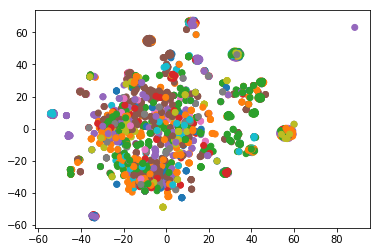

In [16]:

plt.scatter(reduced[:,0], reduced[:,1], color=color_map);